# set up environment

versions that worked:

hssm 0.2.2
pymc 5.14
python 3.11

hssm 0.2.3
pymc newest 

In [13]:
# run on hssm_test
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import numpy as np
import pandas as pd
import pathlib
import seaborn
from pathlib import Path 
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrix
from ssms.basic_simulators.simulator import simulator
import bambi as bmb
from pandas.api.types import CategoricalDtype
import ssms
import pytensor  # Graph-based tensor library
import hssm
# Set float type to float32 to avoid a current bug in PyMC 
# This will not be necessary in the future
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


# set up paths

In [14]:
basepath = '/users/afengler/data/proj_tt/mpib-HSSM-oddball-data'

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/models/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/results/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/plots/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/ppc/hssm/').mkdir(parents=True, exist_ok=True)

# set up data

In [22]:
df = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')

df['response'] = df['accuracy']
# And then modify the 'response' column where the condition is met
df.loc[df['response'] == 0, 'response'] = -1

df.rename(columns={'reactiontime': 'rt'}, inplace=True)
df.rename(columns={'id': 'participant_id'}, inplace=True)

oddballDataDay2 = df[df['response'].notna()]

data=oddballDataDay2[:]
dataForModel = data[data['pupil'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['beta_insula'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['switch_condition_num'].notna()]


dataForModel['switch_condition_num']=isinstance(dataForModel['switch_condition_num'].dtype, CategoricalDtype)

In [33]:
oddballDataDay2

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       1.0  
1                       1.0        -0.174549        -0.033526       1.0  
2                       3.0         0.289645         1.666682       1.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       1.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       1.0  
11285                   1.0        -0.197492        -0.575755       1.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       1.0  
11288                   1.0        -0.133665        -0.081732       1.0  

[11227 rows x 23 columns]

### first look at real data RT

In [5]:
oddballDataDay2.rt.min()

0.0201793451615231

/tmp/ipykernel_4009492/3106038759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oddballDataDay2['rtPlot']=oddballDataDay2['rt']


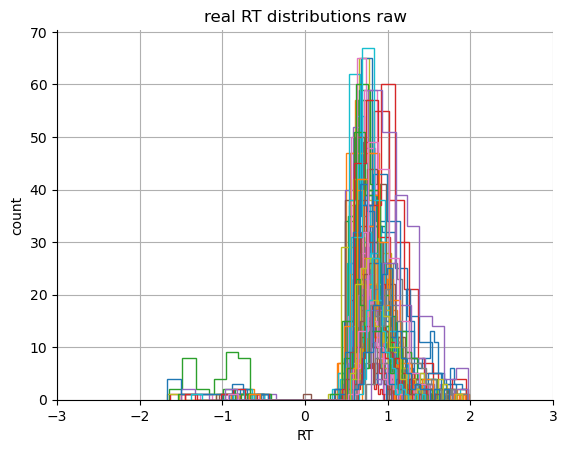

In [4]:
oddballDataDay2['rtPlot']=oddballDataDay2['rt']
oddballDataDay2.loc[oddballDataDay2['response'] == -1,'rtPlot']=oddballDataDay2.loc[oddballDataDay2['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw')
for i, subj_data in oddballDataDay2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/real_subRT_dist.pdf')

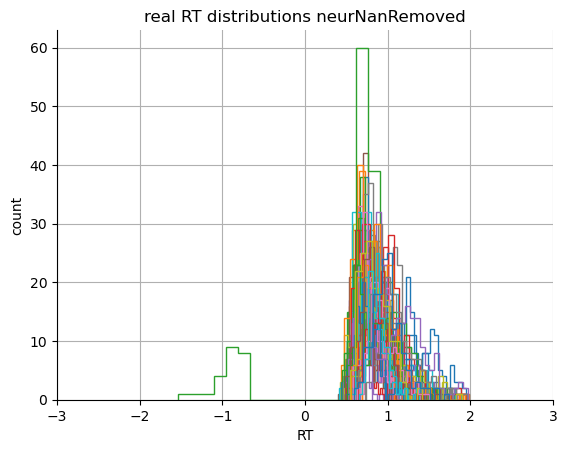

In [5]:
dataForModel['rtPlot']=dataForModel['rt']
dataForModel.loc[dataForModel['response'] == -1,'rtPlot']=dataForModel.loc[dataForModel['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions neurNanRemoved')
for i, subj_data in dataForModel.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/real_subRT_dist_neurNanRemoved.pdf')

### day2SubList

In [16]:
# based on the real data, we figure:
# we need to simulate data with 'participant_id','rt',and 'response' 
# we need to get the correct sub numbers out and also correct trial number (samples in simulation) per subject
day2SubList=oddballDataDay2['participant_id'].unique()
len(day2SubList)


71

In [44]:
day2SubList[70]

62433

In [41]:
type(day2SubList[0])

numpy.int64

In [40]:
oddballDataDay2[oddballDataDay2.participant_id==day2SubList[0]]

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                1           42013       1   48306   50806   -1250   
1                1           42013       1   52293   54793   -1250   
2                1           42013       1   54293   56793   -1250   
3                1           42013       1   57293   59793   -1250   
4                1           42013       1   59293   61793   -1250   
..             ...             ...     ...     ...     ...     ...   
154              1           42013       1  481305  483805   -1250   
155              1           42013       1  483305  485805   -1250   
156              1           42013       1  488305  490805   -1250   
157              1           42013       1  490305  492805   -1250   
158              1           42013       1  493305  495805   -1250   

     trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                 1     70       16        1  ...    -0.010940 -0.997148   
1                 2     74       16        1  ...    -0.065556 -0.771706   
2                 3     78       16        1  ...     0.509185 -0.017799   
3                 4     82       16        1  ...     1.049503 -0.247686   
4                 5     86       16        1  ...    -0.611262  0.441441   
..              ...    ...      ...      ...  ...          ...       ...   
154             155    686       16        1  ...    -1.506909 -1.836383   
155             156    690       16        1  ...    -0.364329  0.239119   
156             157    694       16        1  ...    -0.080525  0.460463   
157             158    698       16        1  ...     0.520716  0.320414   
158             159    702       16        1  ...     2.159591 -3.894434   

        pupil       LCr  trl_condition_bin    switch_condition  \
0    2.175158  0.985568                  1                 NaN   
1   -0.275299  0.985568                  1       stay_standard   
2    1.874566  0.985568                  2   switch_to_oddball   
3   -0.516399  0.985568                  2        stay_oddball   
4    0.710667  0.985568                  1  switch_to_standard   
..        ...       ...                ...                 ...   
154  0.841082  0.985568                  1       stay_standard   
155 -0.612937  0.985568                  1       stay_standard   
156 -1.314931  0.985568                  2   switch_to_oddball   
157  0.014631  0.985568                  1  switch_to_standard   
158  0.199010  0.985568                  1       stay_standard   

     switch_condition_num  logreactiontime logreactiontimez  response  
0                     NaN         0.210081         1.375260       1.0  
1                     1.0        -0.174549        -0.033526       1.0  
2                     3.0         0.289645         1.666682       1.0  
3                     2.0         0.296416         1.691481       1.0  
4                     4.0        -0.418396        -0.926666       1.0  
..                    ...              ...              ...       ...  
154                   1.0        -0.466050        -1.101207       1.0  
155                   1.0        -0.207571        -0.154476       1.0  
156                   3.0         0.210828         1.377997       1.0  
157                   4.0        -0.239842        -0.272674       1.0  
158                   1.0         0.025520         0.699270       1.0  

[159 rows x 23 columns]

# set up sampler for real data

In [5]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=oddballDataDay2,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [7]:
ddm_simple_allFree_hier._initvals


{'v_Intercept': array(0., dtype=float32),
 'v_1|participant_id_sigma': array(0.2708236, dtype=float32),
 'v_1|participant_id': array([-7.6181879e-03, -9.6288917e-04,  4.9474364e-04,  8.9970399e-03,
        -4.5653214e-03,  2.6056988e-03, -9.1532692e-03, -2.1170431e-03,
         8.4916539e-03, -1.7512753e-03,  1.6235801e-03,  9.2402920e-03,
         1.7212994e-03, -8.5418336e-03, -7.5415578e-03, -5.6232288e-03,
         2.2886074e-03,  6.6763479e-03,  3.6369970e-03, -3.4151440e-03,
        -4.1940733e-04, -9.4269281e-03, -2.1147372e-03, -8.6767022e-03,
         5.0138151e-03, -9.8811332e-03, -7.3427046e-03, -8.9206593e-03,
         9.5783444e-03, -1.0223742e-04,  1.0129651e-03,  9.0419938e-04,
        -9.9026514e-03, -5.6823315e-03, -4.4843674e-04,  2.0939831e-03,
         3.4465592e-03,  7.1340688e-03, -8.9192605e-03,  7.3926584e-03,
         3.3749915e-03, -1.9553076e-03, -6.4887316e-03,  5.4030605e-03,
         3.8617768e-03,  7.5358883e-03,  5.9242668e-03, -2.8348045e-04,
        -6

In [6]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=3000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



2024-09-02 09:58:56.866016: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [21]:
pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_hier.nc'
data = inferenceData_ddm_simple_allFree_hier
az.to_netcdf(data, fileName)

NameError: name 'inferenceData_ddm_simple_allFree_hier' is not defined

In [23]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_hier.nc'
ddm_inferenceData=az.from_netcdf(fileName)
ddm_inferenceData

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [25]:
az.summary(ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept  4.795  0.248   4.508    5.192      0.124    0.095       4.0   
a_Intercept  3.044  0.156   2.797    3.211      0.078    0.060       4.0   
z_Intercept  0.435  0.009   0.421    0.447      0.005    0.004       4.0   
t_Intercept  0.031  0.003   0.028    0.037      0.002    0.001       4.0   

             ess_tail         r_hat  
v_Intercept       4.0  5.573330e+15  
a_Intercept       4.0  5.573330e+15  
z_Intercept       4.0  5.573330e+15  
t_Intercept       4.0  5.573330e+15

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite

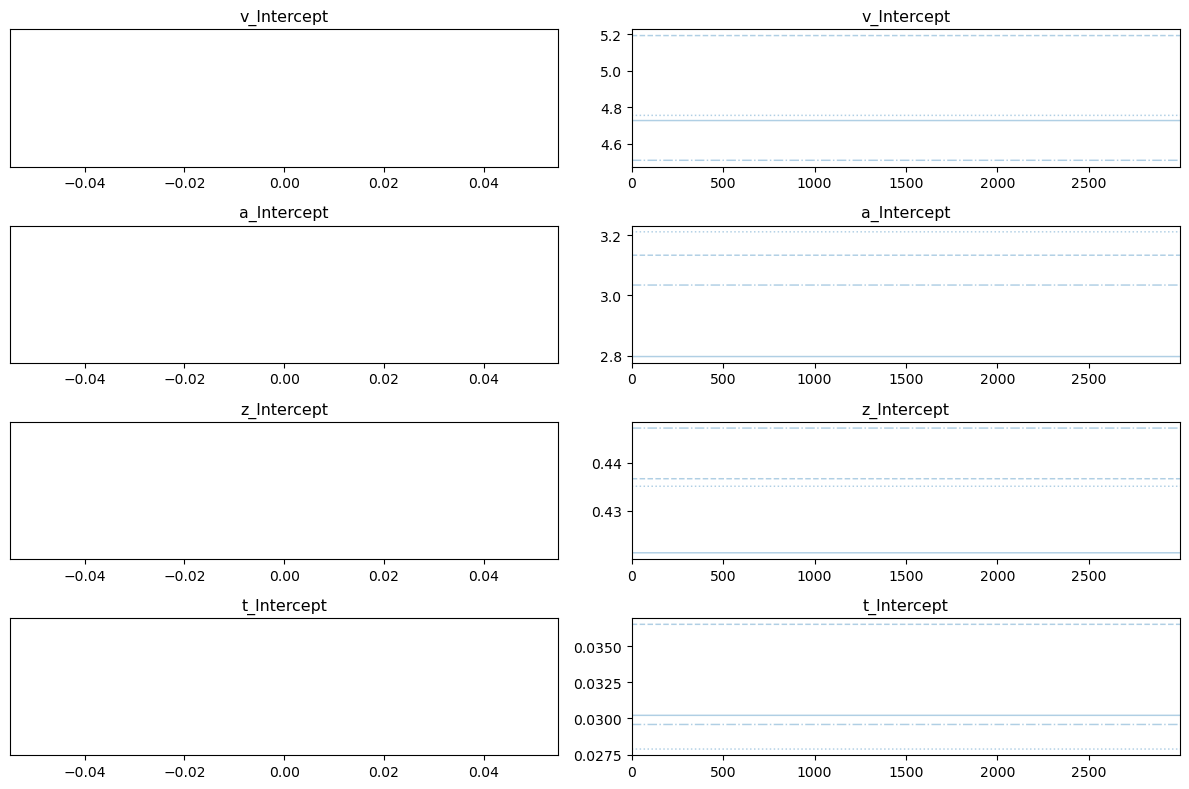

In [26]:
az.plot_trace(
    ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

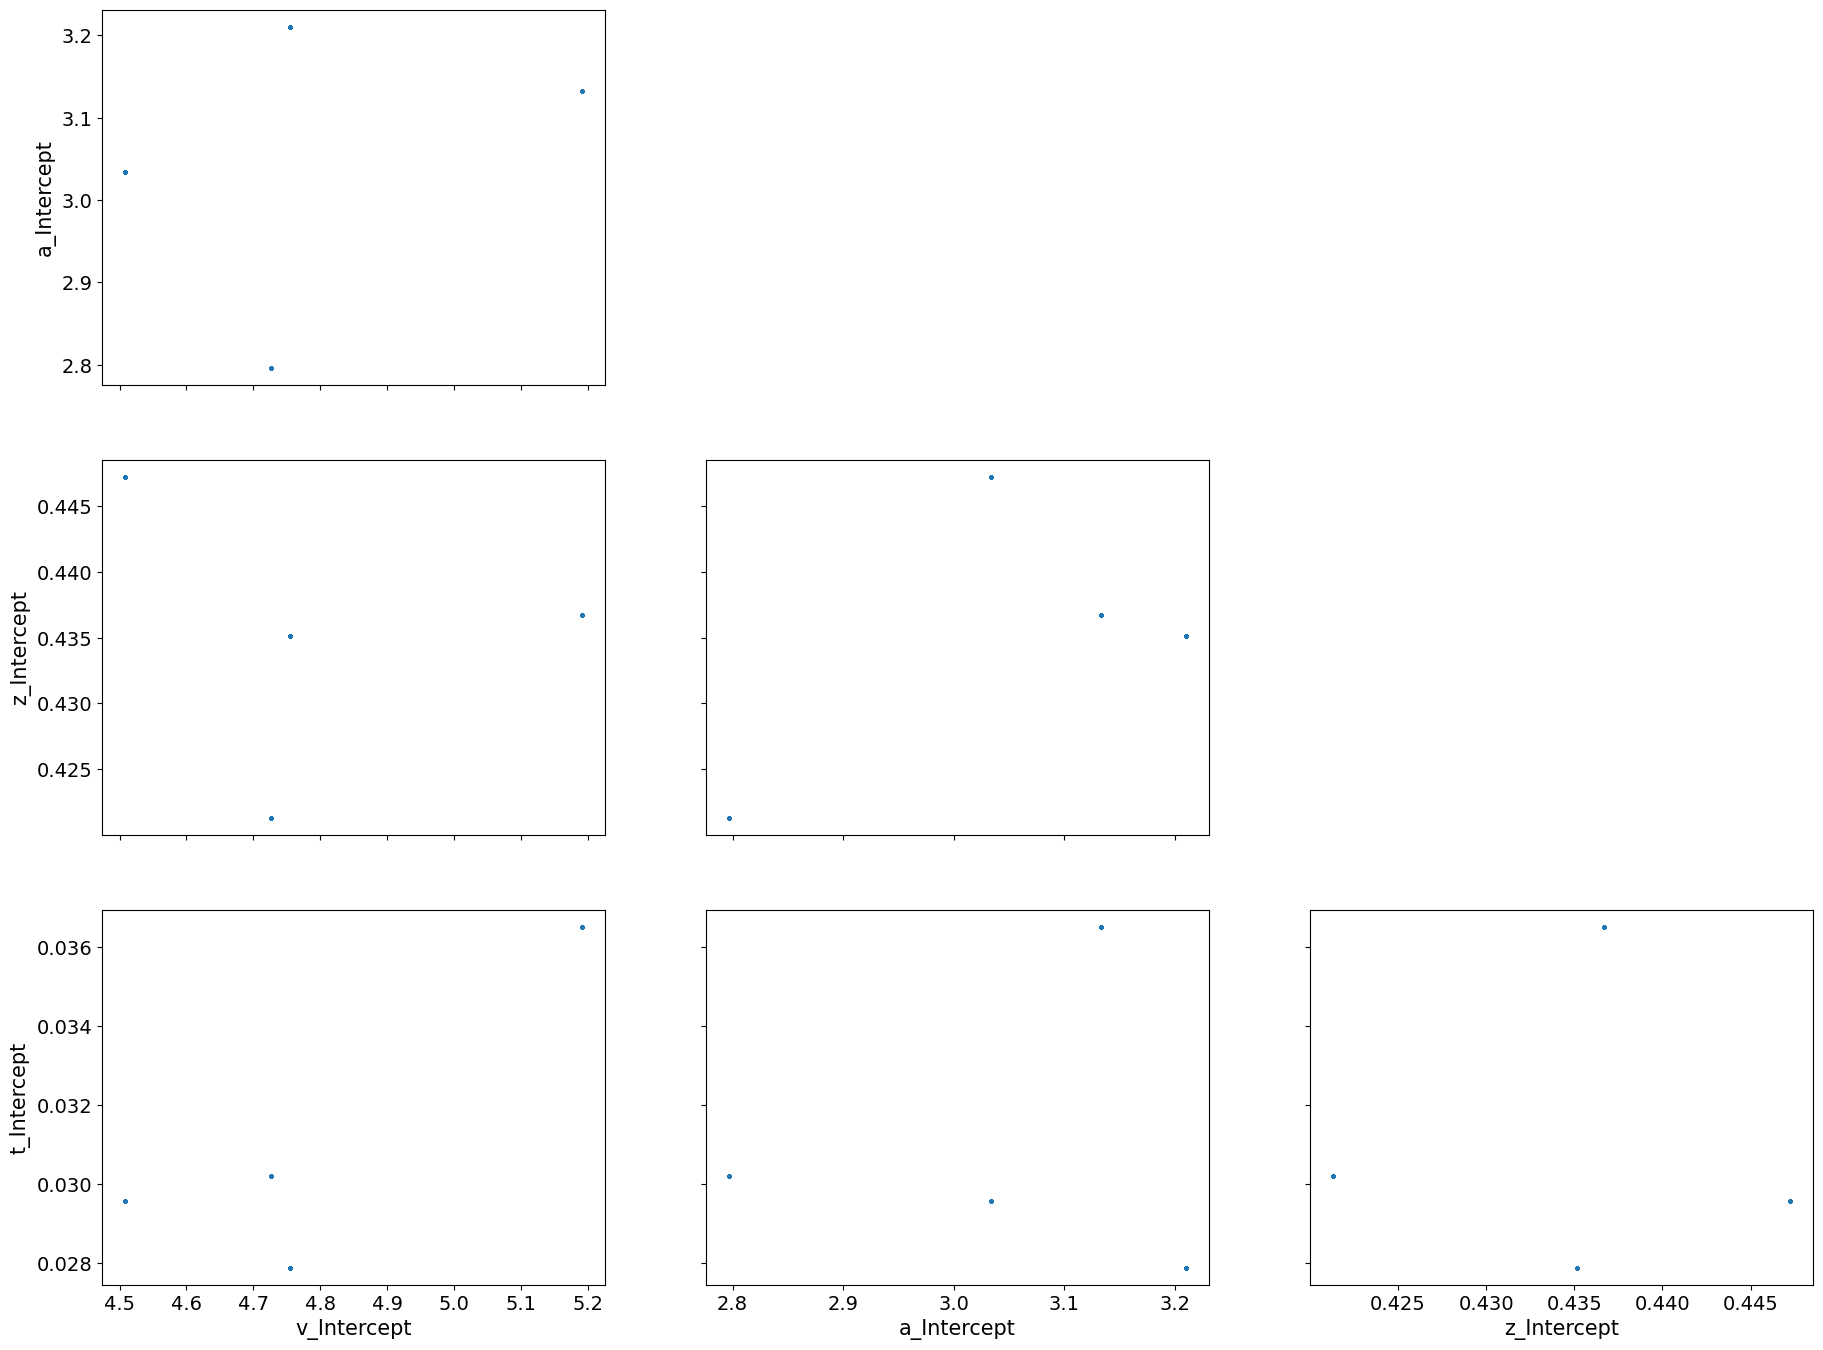

In [27]:
az.plot_pair(ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

In [28]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_noHier.nc'
ddm_inferenceData_noHier=az.from_netcdf(fileName)
ddm_inferenceData_noHier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [30]:
az.summary(ddm_inferenceData_noHier,var_names=['v','a','z','t'])

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v  0.000  0.0   0.000    0.000        0.0      0.0    6000.0    6000.0    NaN
a  1.500  0.0   1.500    1.500        0.0      0.0    6000.0    6000.0    NaN
z  0.500  0.0   0.500    0.500        0.0      0.0    6000.0    6000.0    NaN
t  0.025  0.0   0.025    0.025        0.0      0.0    6000.0    6000.0    NaN

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite

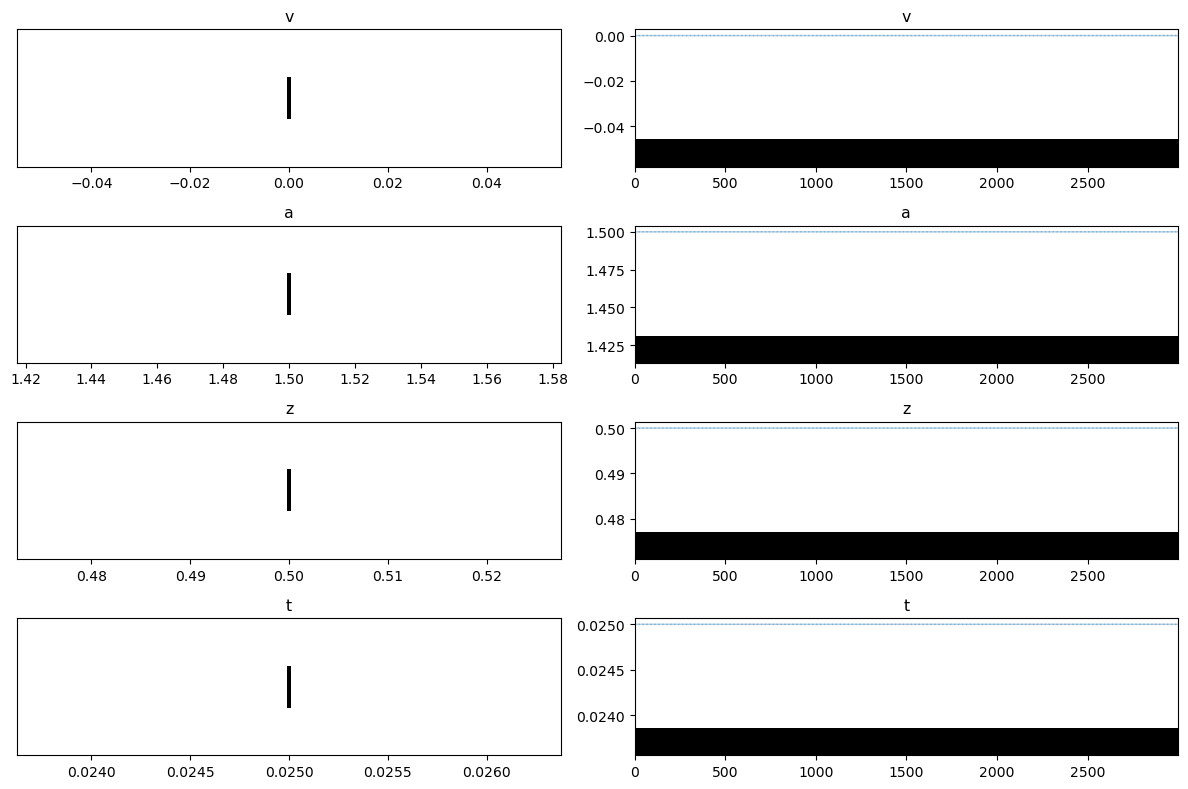

In [31]:
az.plot_trace(
    ddm_inferenceData_noHier,var_names=['v','a','z','t']
)
plt.tight_layout()

array([[<Axes: ylabel='a'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v', ylabel='t'>, <Axes: xlabel='a'>,
        <Axes: xlabel='z'>]], dtype=object)

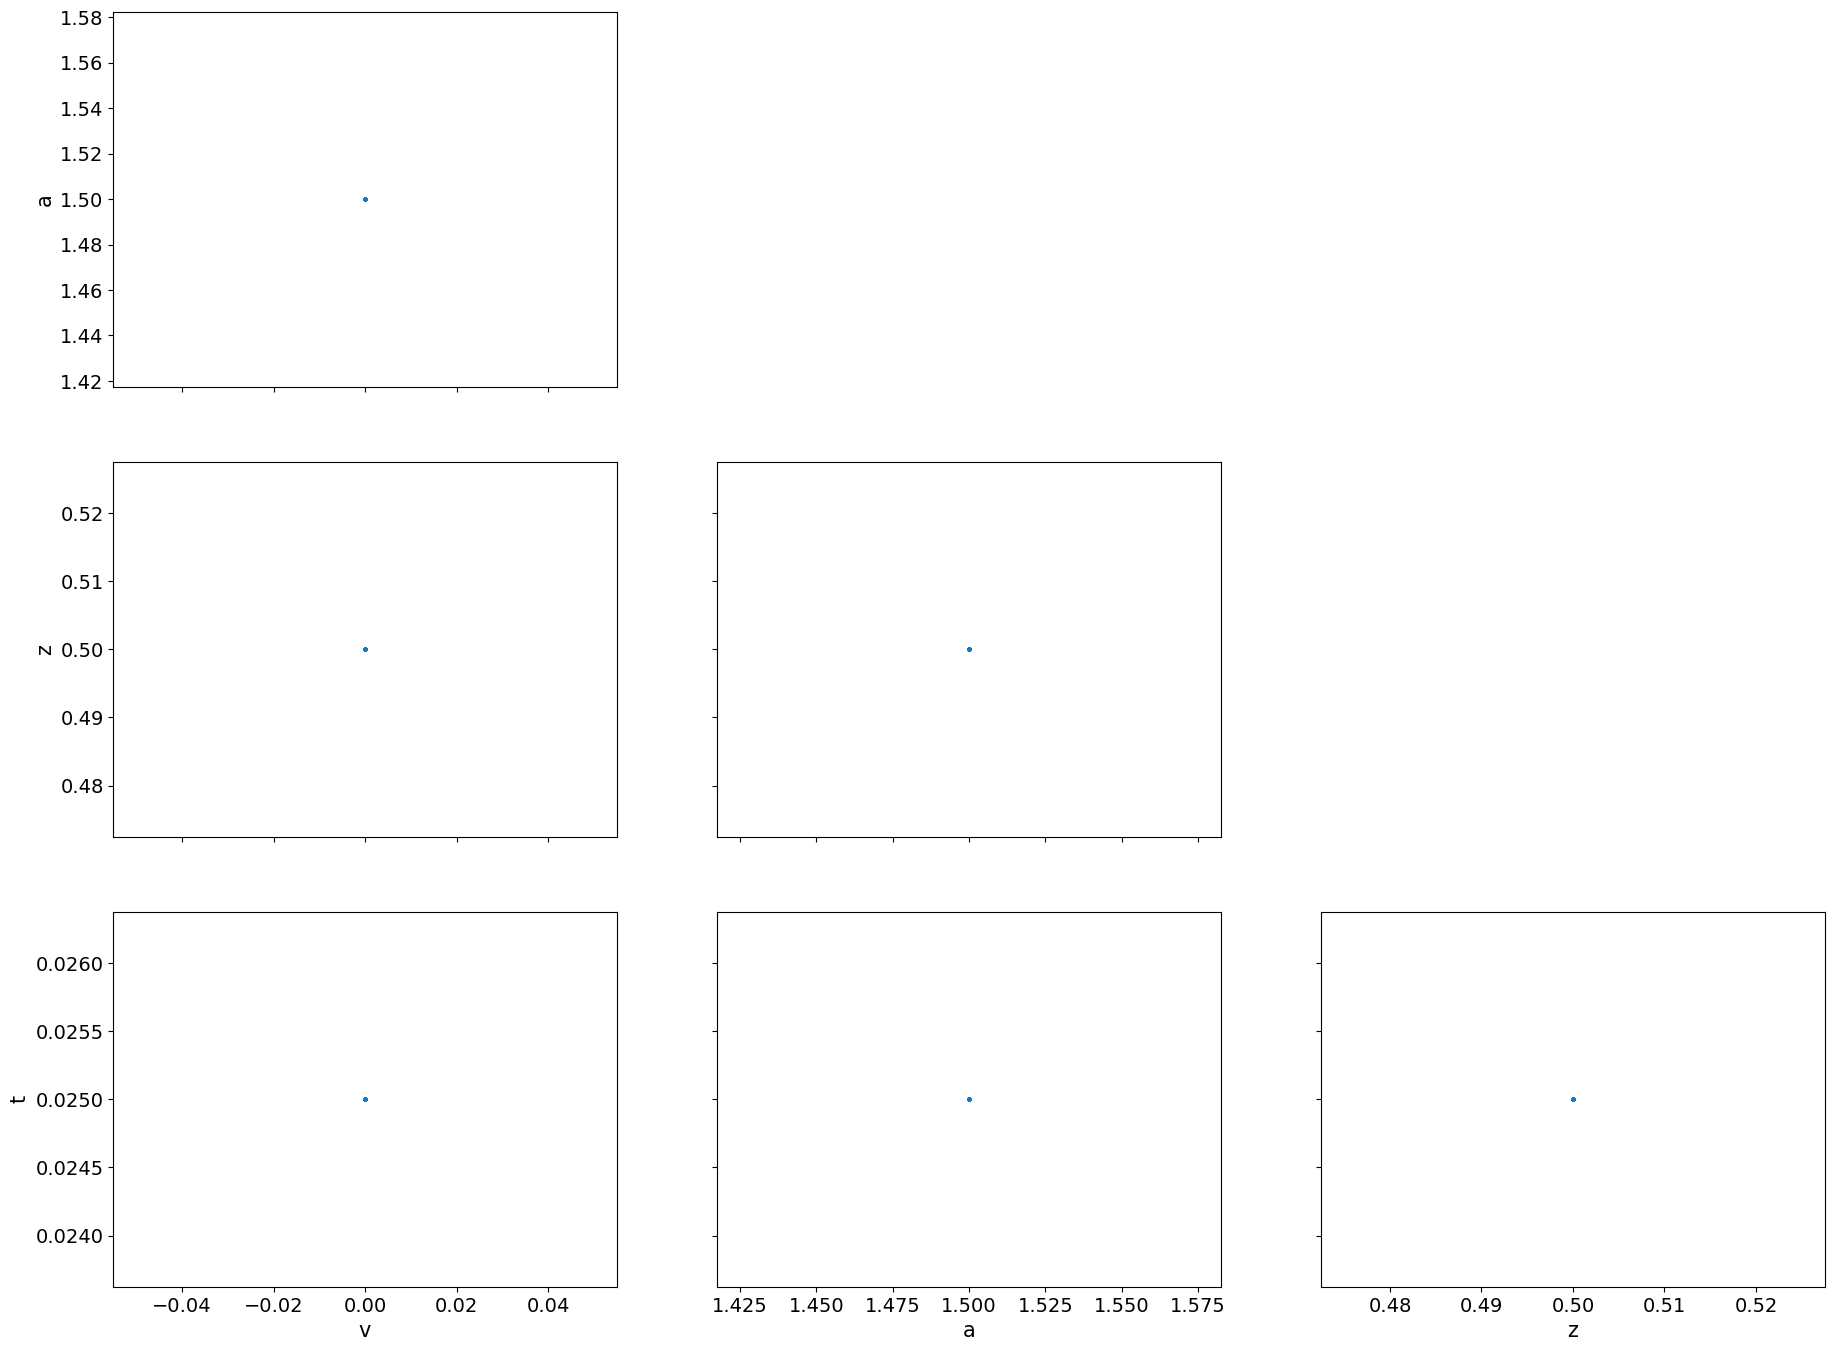

In [32]:
az.plot_pair(ddm_inferenceData_noHier,var_names=['v','a','z','t'])

# simulate data: simplest DDM all params free

## nuts numpyro

In [8]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7f90a0f72260>}

In [82]:
vanillaHDDMallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(2,0.05), 
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simData=pd.concat([vanillaHDDMallFree_simData, subDataset], ignore_index=True)

In [83]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  0.539640       1.0
1             42013.0  0.744280       1.0
2             42013.0  0.505983       1.0
3             42013.0  1.406529       1.0
4             42013.0  0.910031       1.0
...               ...       ...       ...
11222         62433.0  0.927285       1.0
11223         62433.0  0.593821       1.0
11224         62433.0  0.482578       1.0
11225         62433.0  0.547123       1.0
11226         62433.0  0.521996       1.0

[11227 rows x 3 columns]

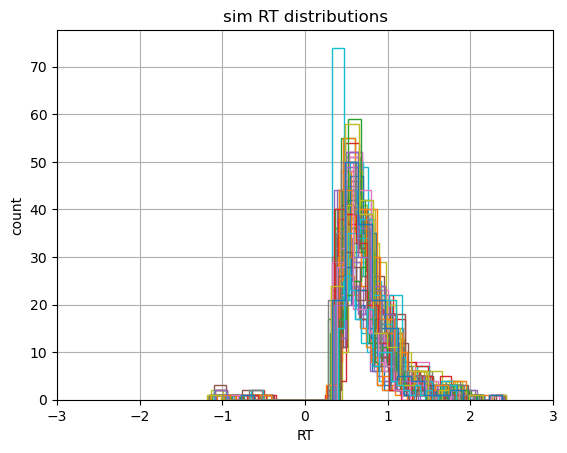

In [84]:
vanillaHDDMallFree_simData['rtPlot']=vanillaHDDMallFree_simData['rt']
vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']=vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions')
for i, subj_data in vanillaHDDMallFree_simData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist.pdf')

In [85]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=vanillaHDDMallFree_simData,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [81]:
ddm_simple_allFree_hier

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 11084

Parameters:

v:
    Formula: v ~ 1 + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + (1|participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1 + (1|participant_id)
    Priors:
        t_Intercept ~ Gamma(mu: 

In [86]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [87]:
inferenceData_ddm_simple_allFree_hier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

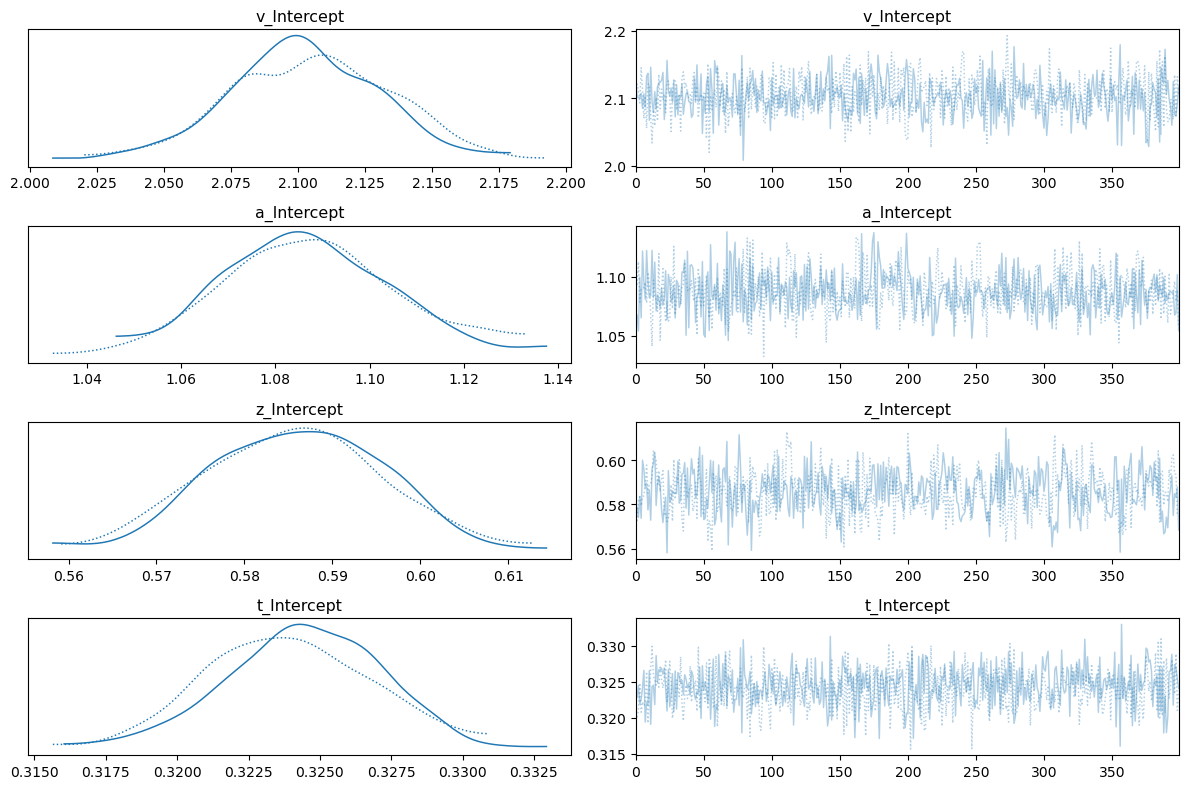

In [88]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

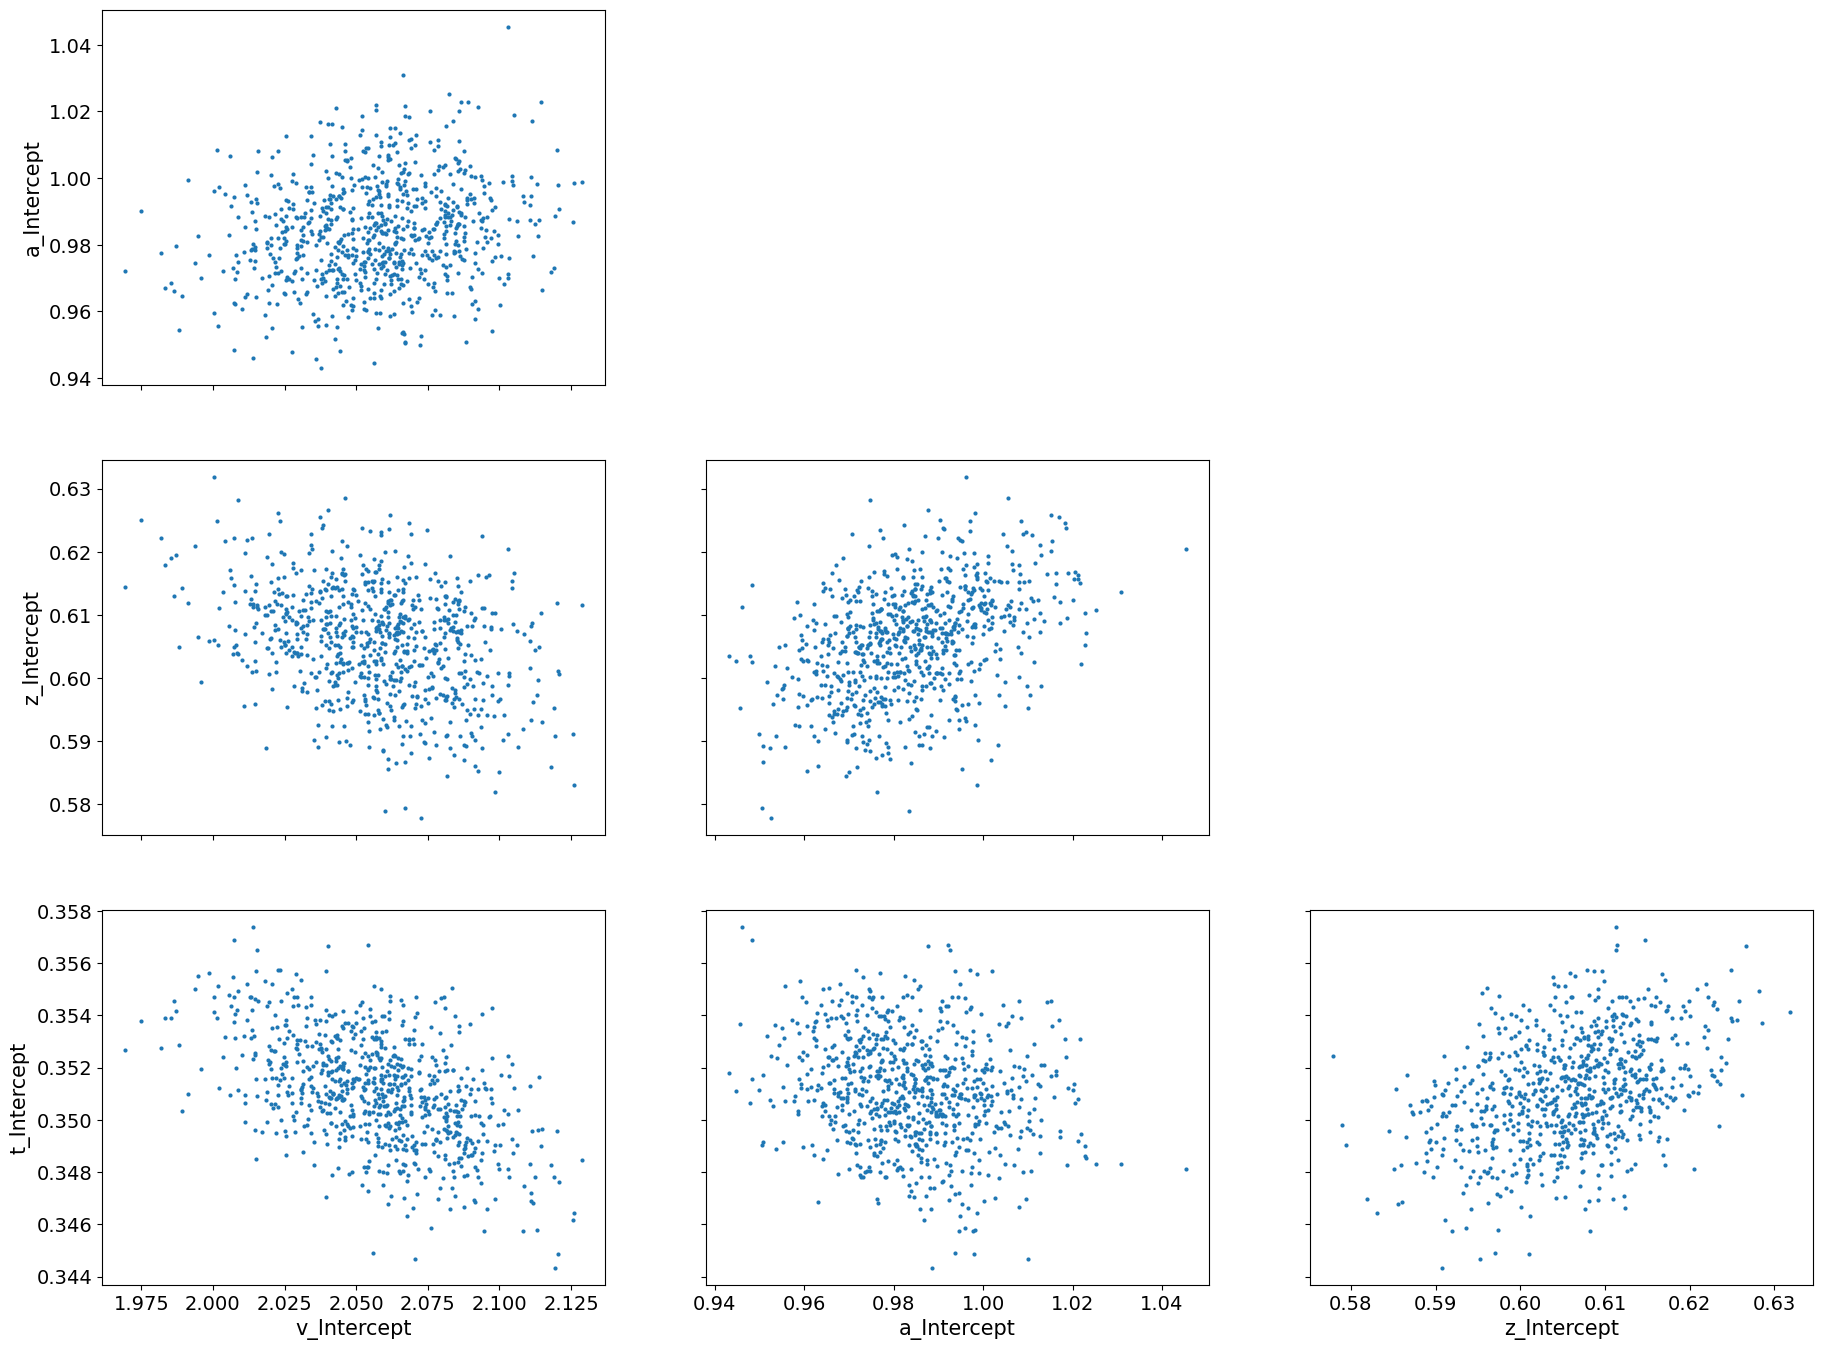

In [78]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

### play around with the ground truth params to simulate data with more errors

In [64]:
vanillaHDDMallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(dataForModel.loc[dataForModel['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(0.1,0.005), #play with v, closer to zero will lead to more even upper and lower bound choices
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simDataEvenChoice=pd.concat([vanillaHDDMallFree_simDataEvenChoice, subDataset], ignore_index=True)
    
vanillaHDDMallFree_simDataEvenChoice    

participant_id        rt  response
0             42013.0  2.414007       1.0
1             42013.0  1.059152       1.0
2             42013.0  1.028316      -1.0
3             42013.0  1.948087       1.0
4             42013.0  1.812551      -1.0
...               ...       ...       ...
11079         62433.0  0.598226       1.0
11080         62433.0  1.437814       1.0
11081         62433.0  1.256375      -1.0
11082         62433.0  0.573281       1.0
11083         62433.0  2.346781       1.0

[11084 rows x 3 columns]

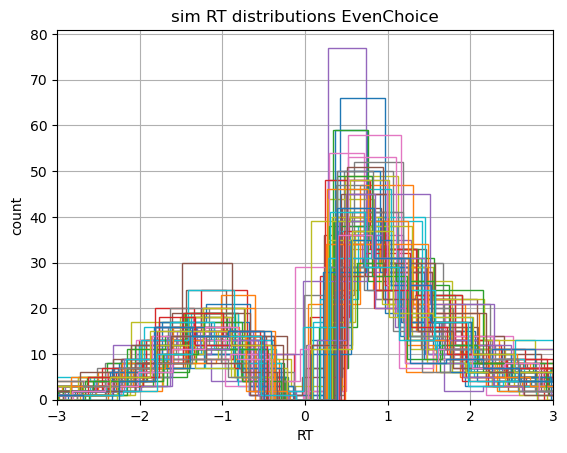

In [66]:
vanillaHDDMallFree_simDataEvenChoice['rtPlot']=vanillaHDDMallFree_simDataEvenChoice['rt']
vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']=vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions EvenChoice')
for i, subj_data in vanillaHDDMallFree_simDataEvenChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist_even.pdf')

In [72]:
ddm_simple_allFree_hier_even = hssm.HSSM(
    data=vanillaHDDMallFree_simDataEvenChoice,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [73]:
inferenceData_ddm_simple_allFree_hier_even=ddm_simple_allFree_hier_even.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [75]:
inferenceData_ddm_simple_allFree_hier_even

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

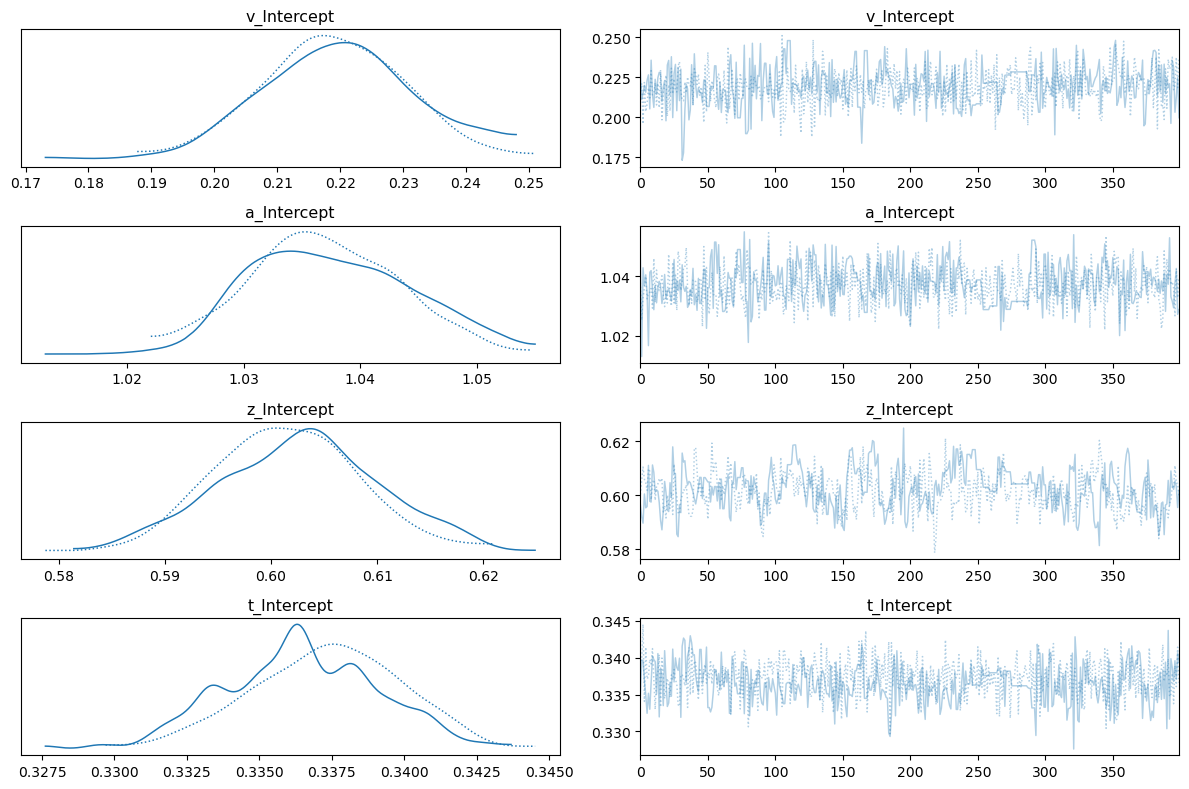

In [76]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

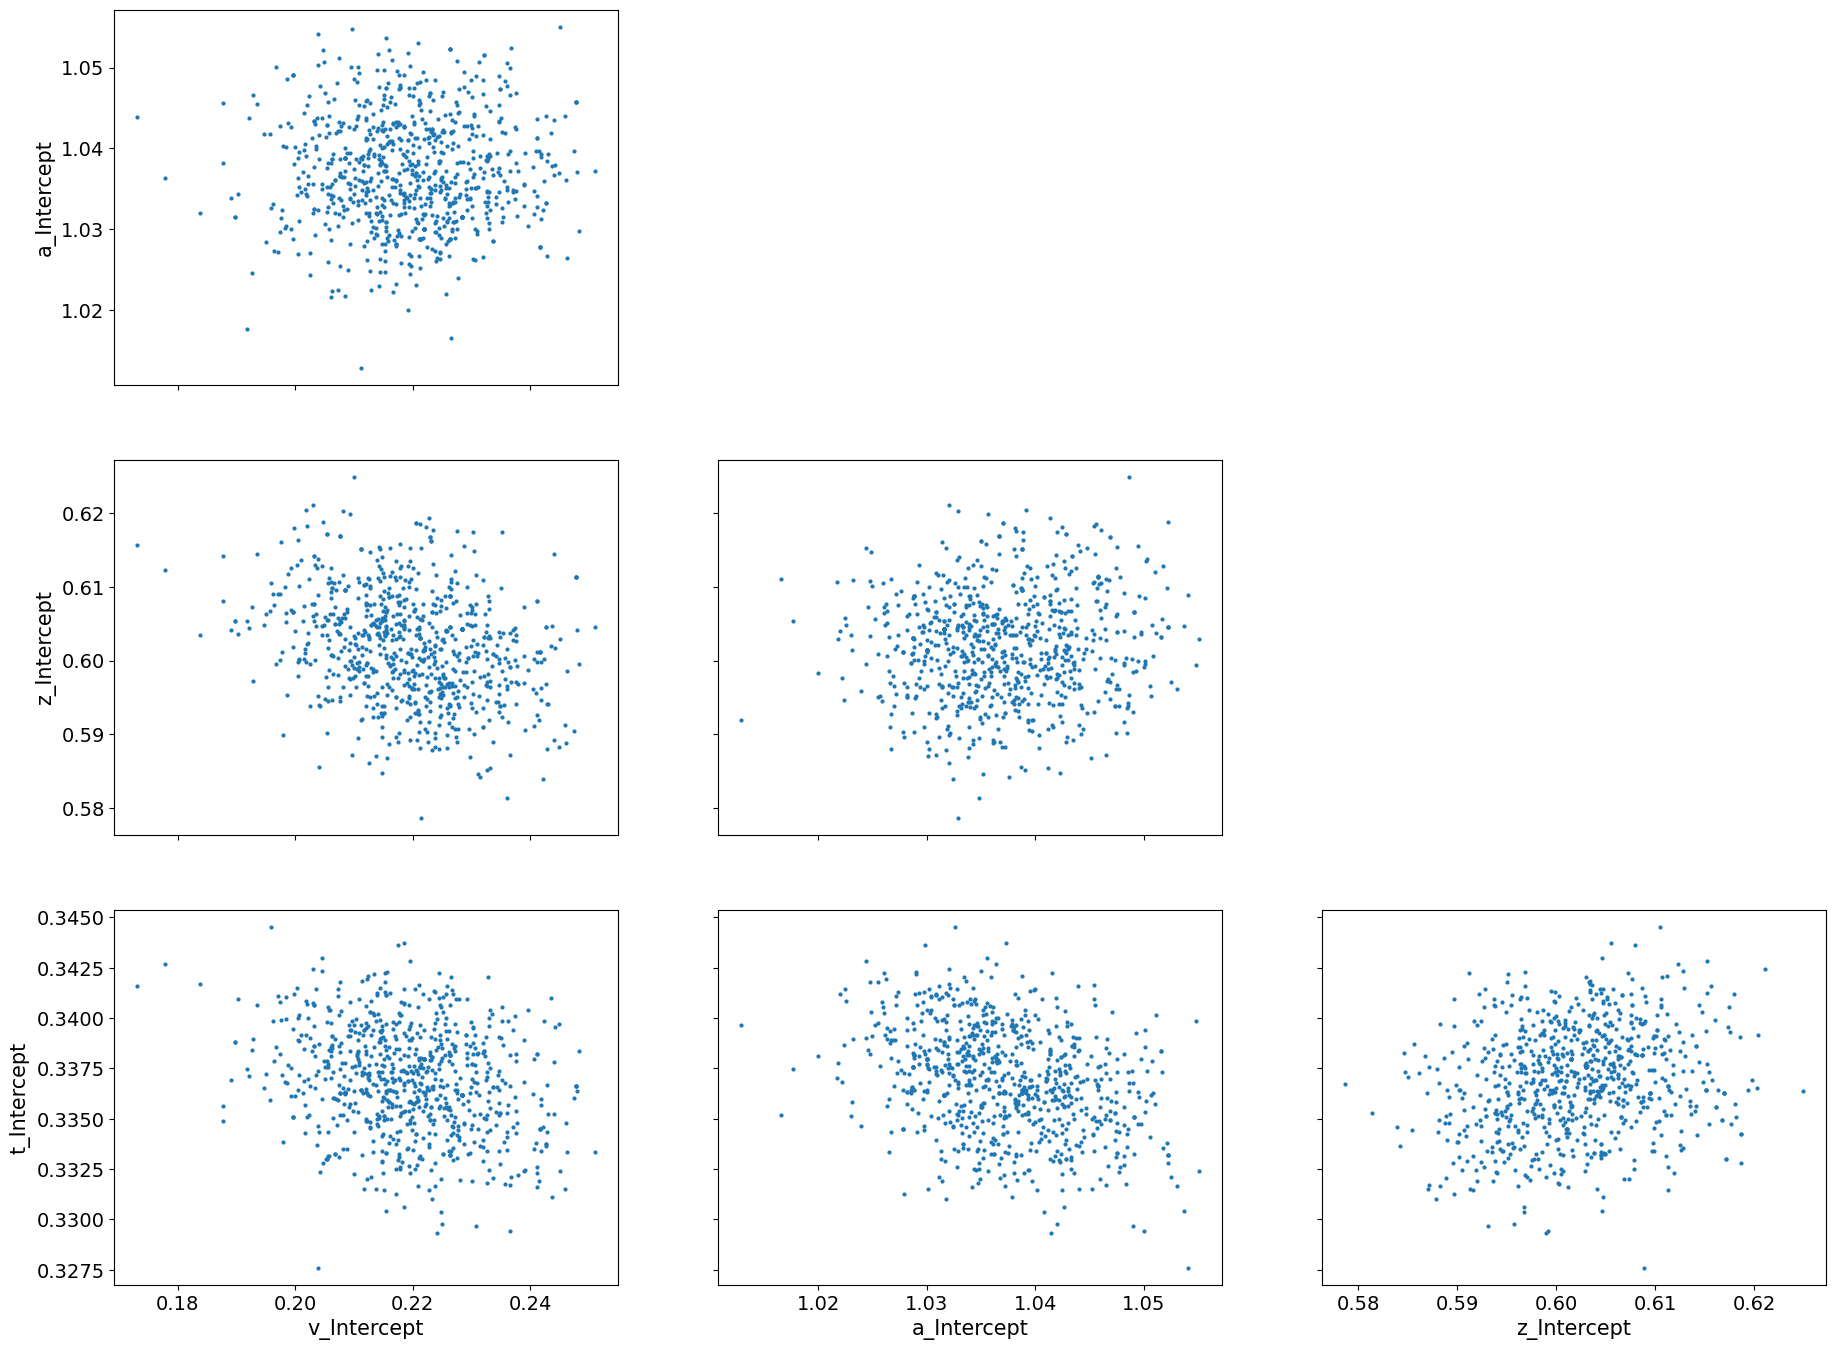

In [79]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

## nuts numpyro with ground truth from real data instead 

In [ ]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7f90a0f72260>}

In [52]:
vanillaHDDMallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(2.021,0.005), 
                                      np.random.normal(1.405,0.068), 
                                      np.random.normal(0.573,0.056),
                                      np.random.normal(0.372,0.029)]


    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simData=pd.concat([vanillaHDDMallFree_simData, subDataset], ignore_index=True)

In [ ]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  0.392496       1.0
1             42013.0  0.439485       1.0
2             42013.0  0.707260       1.0
3             42013.0  0.626655       1.0
4             42013.0  0.573257       1.0
...               ...       ...       ...
11079         62433.0  1.079464       1.0
11080         62433.0  0.844995       1.0
11081         62433.0  0.418700       1.0
11082         62433.0  0.431456       1.0
11083         62433.0  0.945176       1.0

[11084 rows x 3 columns]

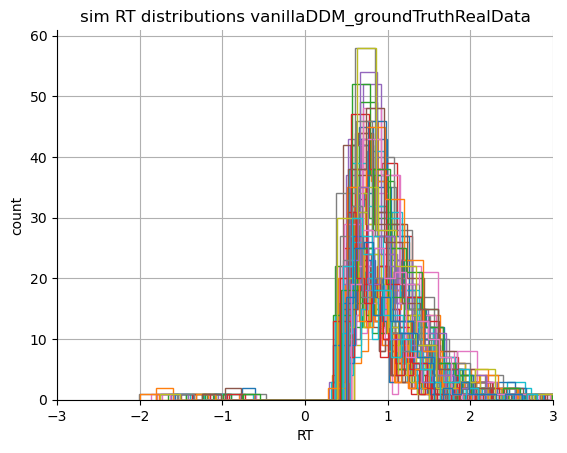

In [27]:
vanillaHDDMallFree_simData['rtPlot']=vanillaHDDMallFree_simData['rt']
vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']=vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']*-1
fig = plt.figure()

ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions vanillaDDM_groundTruthRealData')
for i, subj_data in vanillaHDDMallFree_simData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/sim_subRT_dist_vanillaDDM_groundTruthRealData.pdf')

In [10]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=vanillaHDDMallFree_simData,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [11]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=4,
    draws=3000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



2024-09-01 16:59:56.993206: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [14]:
pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_sim_ddm_simple_allFree_hier.nc'
data = inferenceData_ddm_simple_allFree_hier
az.to_netcdf(data, fileName)

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/ddm/sept24/numpyro/inferenceData_sim_ddm_simple_allFree_hier.nc'

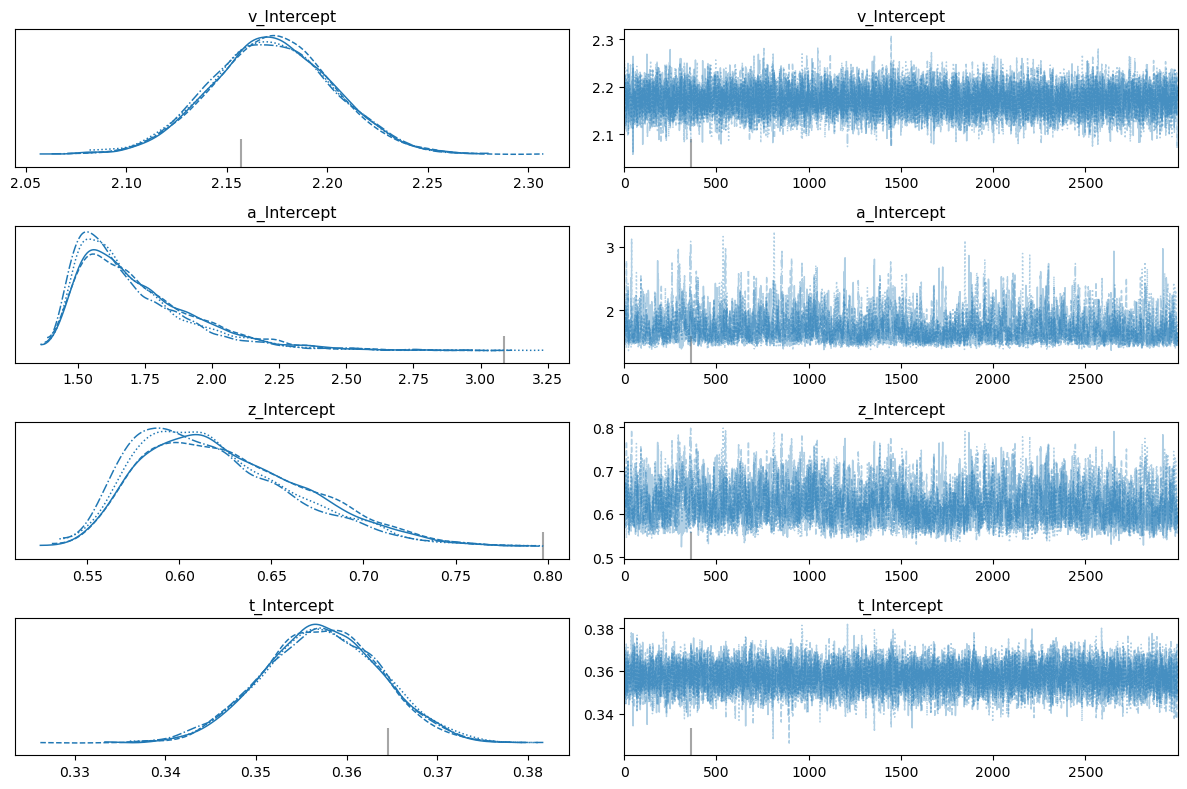

In [15]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

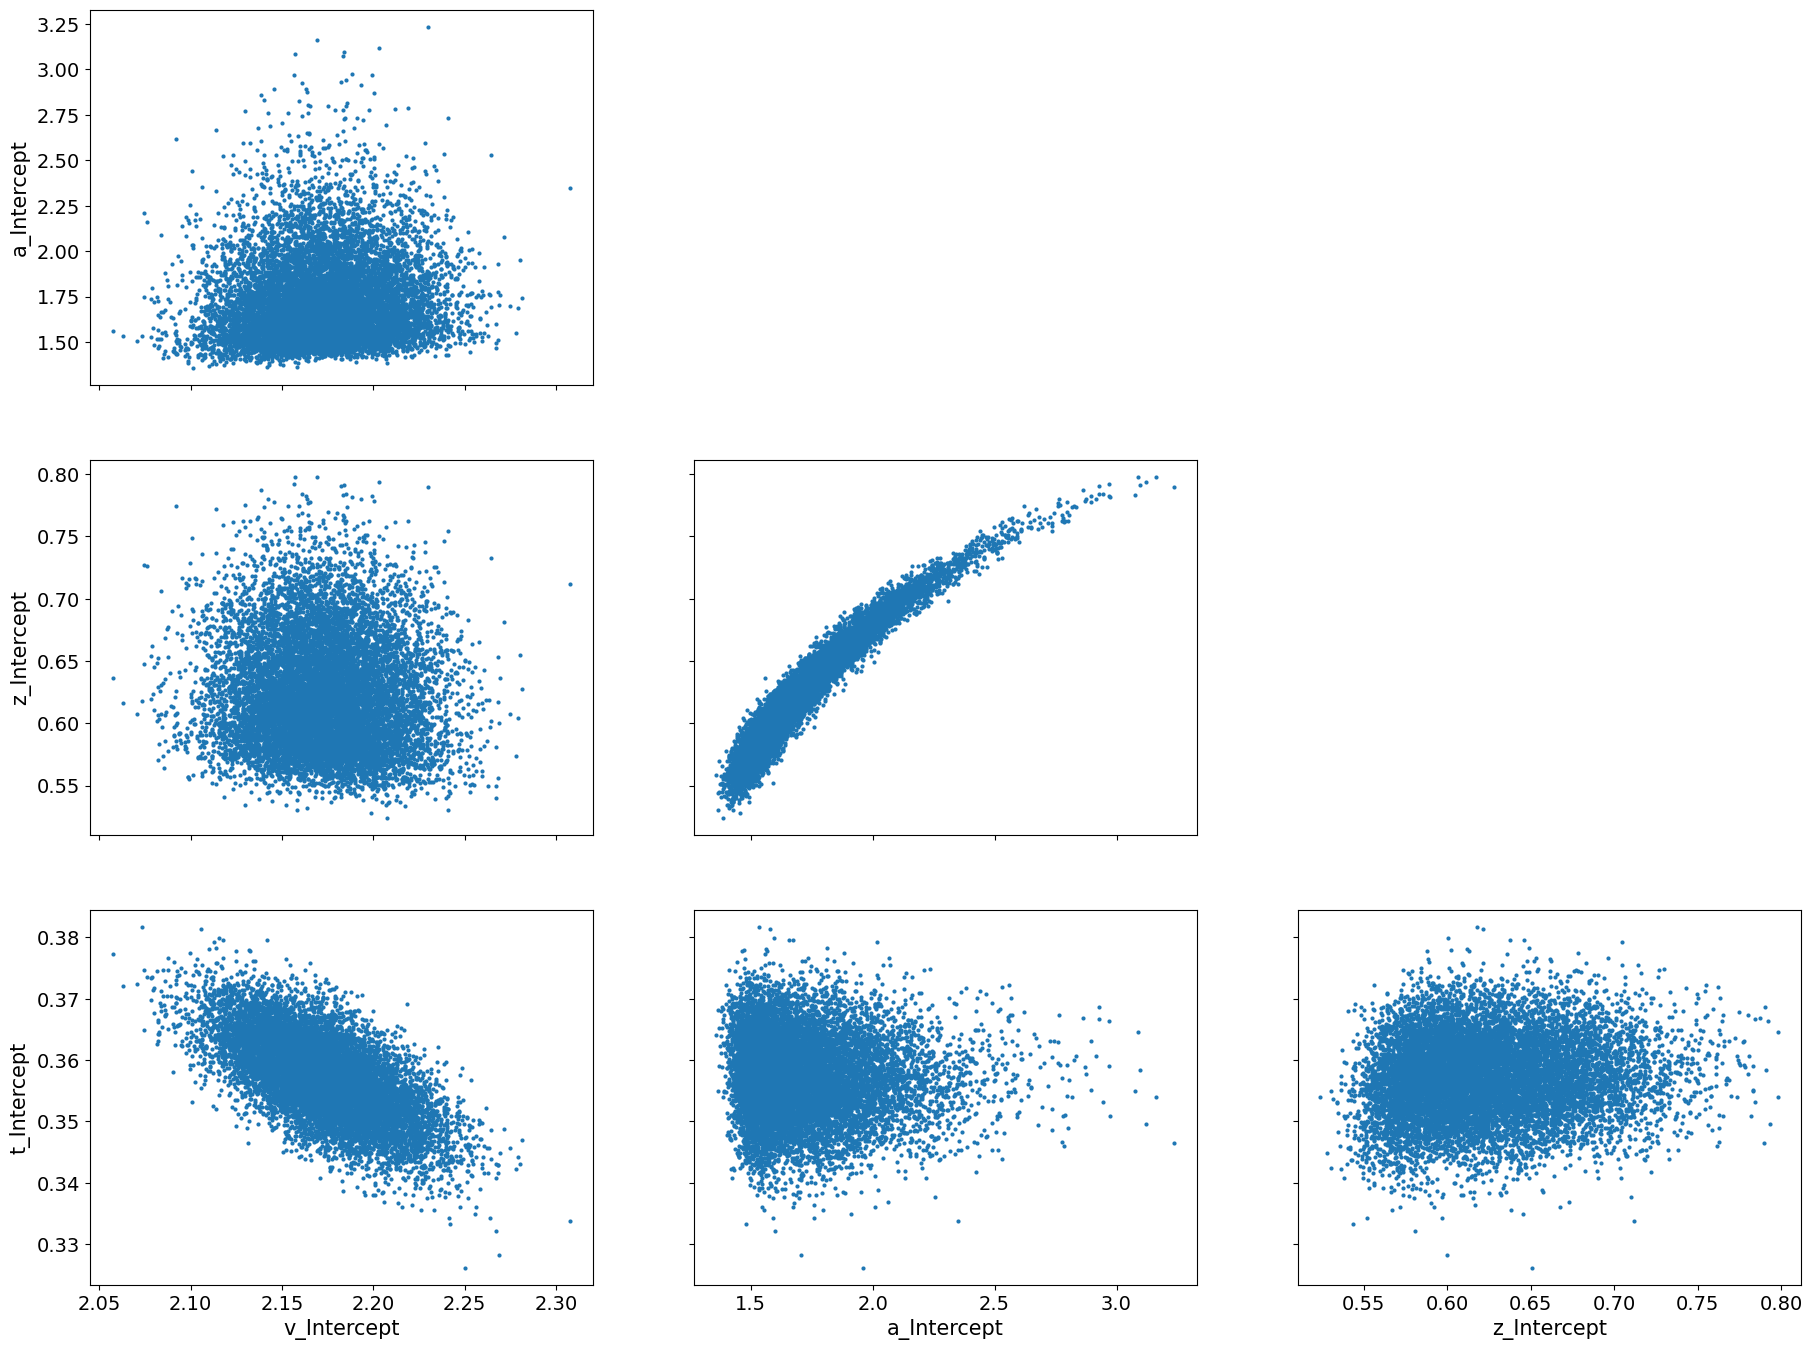

In [28]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

### play around with the ground truth params to simulate data with more errors

In [9]:
vanillaHDDMallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(0.1,0.005), 
                                      np.random.normal(1,0.068), 
                                      np.random.normal(0.573,0.056),
                                      np.random.normal(0.372,0.029)]

                                    #   [np.random.normal(0.1,0.005), #play with v, closer to zero will lead to more even upper and lower bound choices
                                    #   np.random.normal(1,0.05), 
                                    #   np.random.normal(0.6,0.05),
                                    #   np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simDataEvenChoice=pd.concat([vanillaHDDMallFree_simDataEvenChoice, subDataset], ignore_index=True)
    
vanillaHDDMallFree_simDataEvenChoice    

participant_id        rt  response
0             42013.0  1.264370       1.0
1             42013.0  1.602756       1.0
2             42013.0  0.587306       1.0
3             42013.0  0.696137       1.0
4             42013.0  0.945371      -1.0
...               ...       ...       ...
11222         62433.0  1.000878       1.0
11223         62433.0  0.764156       1.0
11224         62433.0  0.650539       1.0
11225         62433.0  2.051321       1.0
11226         62433.0  2.801191       1.0

[11227 rows x 3 columns]

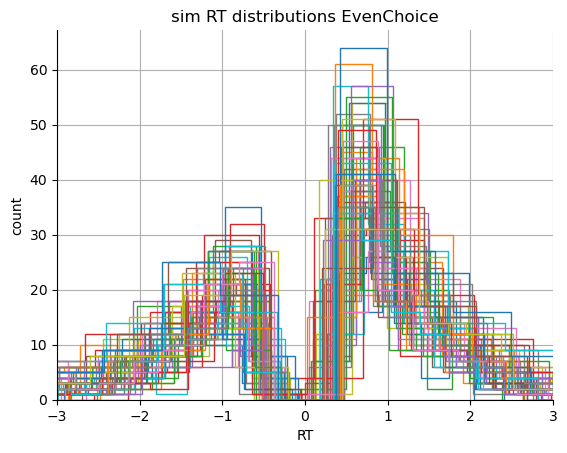

In [10]:
vanillaHDDMallFree_simDataEvenChoice['rtPlot']=vanillaHDDMallFree_simDataEvenChoice['rt']
vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']=vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions EvenChoice')
for i, subj_data in vanillaHDDMallFree_simDataEvenChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/sim_subRT_dist_vanillaDDM_groundTruthRealDataEvenChoice.pdf')

In [11]:
ddm_simple_allFree_hier_even = hssm.HSSM(
    data=vanillaHDDMallFree_simDataEvenChoice,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [12]:
inferenceData_ddm_simple_allFree_hier_even=ddm_simple_allFree_hier_even.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=3000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

TypeError: ('Vector(float32, shape=(?,)) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to float32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([0.12650143, 0.12650143, 0.12650143, ..., 0.13929928, 0.13929928,\n       0.13929928])"', 'Container name "v"')

In [17]:
pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_sim_evenChoice_ddm_simple_allFree_hier.nc'
data = inferenceData_ddm_simple_allFree_hier_even
az.to_netcdf(data, fileName)

NameError: name 'inferenceData_ddm_simple_allFree_hier_even' is not defined

In [18]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_sim_evenChoice_ddm_simple_allFree_hier.nc'
ddm_inferenceData_sim_evenChoice=az.from_netcdf(fileName)
ddm_inferenceData_sim_evenChoice

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

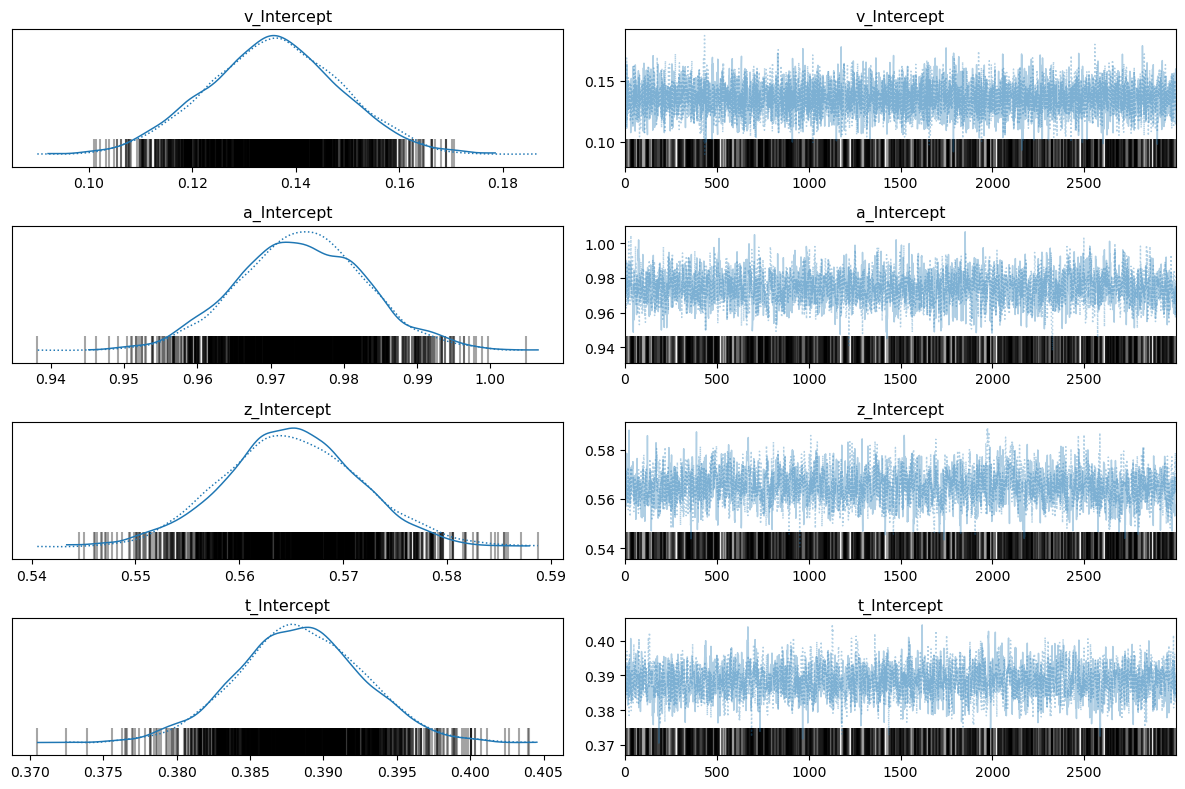

In [19]:
az.plot_trace(
    ddm_inferenceData_sim_evenChoice,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

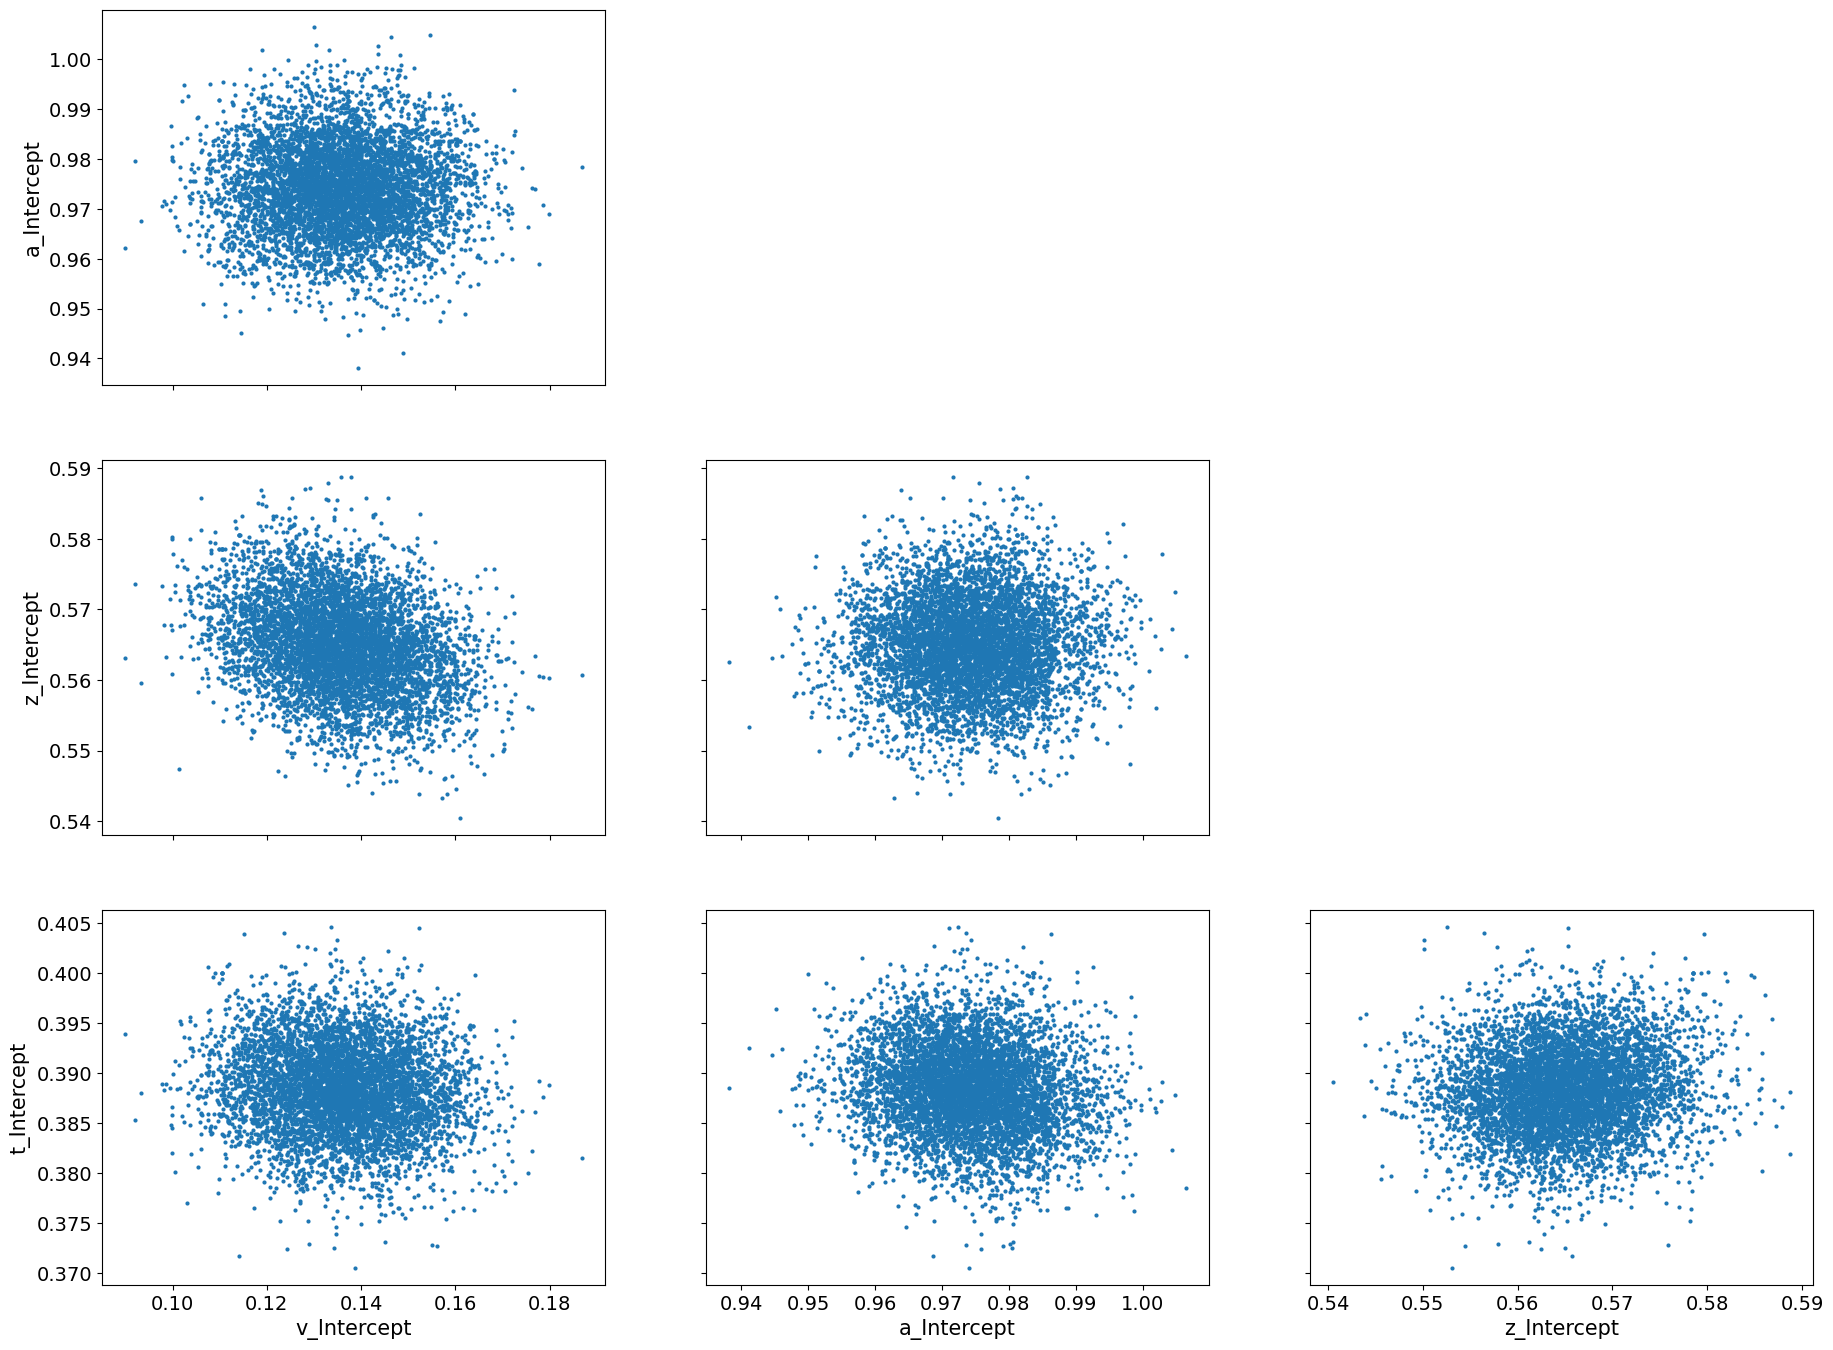

In [20]:
az.plot_pair(ddm_inferenceData_sim_evenChoice,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

In [47]:
subID=day2SubList[0]
subID

42013

In [48]:
subData=oddballDataDay2[oddballDataDay2.participant_id==subID]
subData

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                1           42013       1   48306   50806   -1250   
1                1           42013       1   52293   54793   -1250   
2                1           42013       1   54293   56793   -1250   
3                1           42013       1   57293   59793   -1250   
4                1           42013       1   59293   61793   -1250   
..             ...             ...     ...     ...     ...     ...   
154              1           42013       1  481305  483805   -1250   
155              1           42013       1  483305  485805   -1250   
156              1           42013       1  488305  490805   -1250   
157              1           42013       1  490305  492805   -1250   
158              1           42013       1  493305  495805   -1250   

     trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                 1     70       16        1  ...    -0.010940 -0.997148   
1                 2     74       16        1  ...    -0.065556 -0.771706   
2                 3     78       16        1  ...     0.509185 -0.017799   
3                 4     82       16        1  ...     1.049503 -0.247686   
4                 5     86       16        1  ...    -0.611262  0.441441   
..              ...    ...      ...      ...  ...          ...       ...   
154             155    686       16        1  ...    -1.506909 -1.836383   
155             156    690       16        1  ...    -0.364329  0.239119   
156             157    694       16        1  ...    -0.080525  0.460463   
157             158    698       16        1  ...     0.520716  0.320414   
158             159    702       16        1  ...     2.159591 -3.894434   

        pupil       LCr  trl_condition_bin    switch_condition  \
0    2.175158  0.985568                  1                 NaN   
1   -0.275299  0.985568                  1       stay_standard   
2    1.874566  0.985568                  2   switch_to_oddball   
3   -0.516399  0.985568                  2        stay_oddball   
4    0.710667  0.985568                  1  switch_to_standard   
..        ...       ...                ...                 ...   
154  0.841082  0.985568                  1       stay_standard   
155 -0.612937  0.985568                  1       stay_standard   
156 -1.314931  0.985568                  2   switch_to_oddball   
157  0.014631  0.985568                  1  switch_to_standard   
158  0.199010  0.985568                  1       stay_standard   

     switch_condition_num  logreactiontime logreactiontimez  response  
0                     NaN         0.210081         1.375260       1.0  
1                     1.0        -0.174549        -0.033526       1.0  
2                     3.0         0.289645         1.666682       1.0  
3                     2.0         0.296416         1.691481       1.0  
4                     4.0        -0.418396        -0.926666       1.0  
..                    ...              ...              ...       ...  
154                   1.0        -0.466050        -1.101207       1.0  
155                   1.0        -0.207571        -0.154476       1.0  
156                   3.0         0.210828         1.377997       1.0  
157                   4.0        -0.239842        -0.272674       1.0  
158                   1.0         0.025520         0.699270       1.0  

[159 rows x 23 columns]

In [49]:
    ddm_simple_allFree = hssm.HSSM(
            data=subData,
            model="ddm",
            hierarchical=False,
            noncentered=False,
            link_settings="log_logit",
            prior_settings="safe",   
        )

You set choices to be [-1, 1], but [-1] are missing from your dataset.
Model initialized successfully.


In [50]:
inferenceData_ddm_simple_allFree=ddm_simple_allFree.sample(
        sampler="nuts_numpyro",
        chains=2,
        draws=3000,
        tune=3000,
        idata_kwargs=dict(log_likelihood=True),
        )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

TypeError: ('Vector(float32, shape=(?,)) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to float32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458, 3.48090458,\n       3.48090458, 3.48090458, 3.48090458, 3.48090458])"', 'Container name "v"')

In [53]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  1.961917       1.0
1             42013.0  0.948054       1.0
2             42013.0  0.693631       1.0
3             42013.0  2.383879       1.0
4             42013.0  1.448555       1.0
...               ...       ...       ...
11222         62433.0  0.968349       1.0
11223         62433.0  0.586548       1.0
11224         62433.0  1.579299       1.0
11225         62433.0  0.896862       1.0
11226         62433.0  0.906244       1.0

[11227 rows x 3 columns]

In [54]:
subID=day2SubList[0]
subID

42013

In [55]:
subData=vanillaHDDMallFree_simData[vanillaHDDMallFree_simData.participant_id==subID]
subData

participant_id        rt  response
0           42013.0  1.961917       1.0
1           42013.0  0.948054       1.0
2           42013.0  0.693631       1.0
3           42013.0  2.383879       1.0
4           42013.0  1.448555       1.0
..              ...       ...       ...
154         42013.0  0.600087       1.0
155         42013.0  0.485543       1.0
156         42013.0  1.282663       1.0
157         42013.0  1.344717       1.0
158         42013.0  0.652858       1.0

[159 rows x 3 columns]

In [58]:
    ddm_simple_allFree = hssm.HSSM(
            data=subData,
            model="ddm",
            noncentered=False,
            #link_settings="log_logit",
            #prior_settings="safe",   
        )

You set choices to be [-1, 1], but [-1] are missing from your dataset.
Model initialized successfully.


In [59]:
inferenceData_ddm_simple_allFree=ddm_simple_allFree.sample(
        sampler="nuts_numpyro",
        chains=2,
        draws=3000,
        tune=3000,
        idata_kwargs=dict(log_likelihood=True),
        )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

TypeError: ('Vector(float32, shape=(?,)) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to float32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869, 3.42617869,\n       3.42617869, 3.42617869, 3.42617869, 3.42617869])"', 'Container name "v"')